In [1]:
import findspark
findspark.init()
findspark.find()

'H:\\SPARK'

In [2]:
from pyspark.sql import SparkSession

# Initialize SparkSession with necessary configurations
spark = SparkSession.builder \
    .master("local[*]") \
    .appName('Spark') \
    .config("spark.driver.memory", "15g") \
    .config("spark.hadoop.home.dir", "H:/HADOOP/") \
    .config("spark.hadoop.conf.dir", "H:/HADOOP/etc/hadoop/") \
    .getOrCreate()
    
import sys
sys.path.append("G:\Dissertation_Project")

# Get SparkContext from the SparkSession
sc = spark.sparkContext


In [3]:
spark

### BASE DATASET

In [4]:
base_df = spark.read.csv("../../Data/Custom_Datasets/conversation_datasets_GPT.csv", header=True, inferSchema=True)
base_df.show(10, truncate=False)

+---------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+
|Conversation_ID|Attacker_Helper                                                                                                                                                 |Victim                                                                                                                                                                                         |Conversation_Type|
+---------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------

### PREPROCESSED DATASET

In [5]:
preprocessed_df = spark.read.csv("../../Data/Preprocessed_Datasets/DATASET_FINAL_PREPROCESSED.csv", header=True, inferSchema=True)
preprocessed_df.show(10, truncate=False)

+---------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Convert Conversation Columns into actual Arrays

In [6]:
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import udf
import ast

# UDF to convert string representation of list to actual list
def str_to_array_of_arrays(s):
    # Convert the string to a list and then wrap it inside another list
    return [ast.literal_eval(s)][0]

str_to_array_of_arrays_udf = udf(str_to_array_of_arrays, ArrayType(ArrayType(StringType())))

df = preprocessed_df.withColumn("Attacker_Helper", str_to_array_of_arrays_udf(preprocessed_df["Attacker_Helper"])).withColumn("Victim", str_to_array_of_arrays_udf(preprocessed_df["Victim"]))

df.printSchema()

root
 |-- Conversation_ID: string (nullable = true)
 |-- Attacker_Helper: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- Victim: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- Conversation_Type: integer (nullable = true)



### Loading the pipeline and transforming the data

In [7]:
from pyspark.ml import PipelineModel
from src.CustonTransformers import FlattenTransformer

pipeline_model_path = "./Pipelines/TF-IDF_Pipeline"

pipeline = PipelineModel.load(path=pipeline_model_path)

df_assembled = pipeline.transform(df)

### Splitting the Data

In [8]:
(train_data, test_data) = df_assembled.randomSplit([0.8, 0.2], seed=42)
train_data.show(truncate=False)

+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# NEURAL NETWORK

## Creating a feed forward neural network using keras. 

In [9]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

### Preparing the data to be used as input in the Neural Network

In [10]:
import numpy 

labels = train_data.select('Conversation_Type').rdd.map(lambda row: row.Conversation_Type).collect()
labels_numpy_train = numpy.array(labels)

print("Shape of -labels_numpy_train- array --> {}".format(labels_numpy_train.shape))

features = train_data.select('combined_features').rdd.map(lambda row: row.combined_features).collect()
features_numpy_train = numpy.array(features)

print("Shape of -features_numpy_train- array --> {}".format(features_numpy_train.shape))

###############################################################################################################

labels = test_data.select('Conversation_Type').rdd.map(lambda row: row.Conversation_Type).collect()
labels_numpy_test = numpy.array(labels)

print("Shape of -labels_numpy_test- array --> {}".format(labels_numpy_test.shape))

features = test_data.select('combined_features').rdd.map(lambda row: row.combined_features).collect()
features_numpy_test = numpy.array(features)

print("Shape of -features_numpy_test- array --> {}".format(features_numpy_test.shape))

Shape of -labels_numpy_train- array --> (2923,)
Shape of -features_numpy_train- array --> (2923, 400)
Shape of -labels_numpy_train- array --> (665,)
Shape of -features_numpy_train- array --> (665, 400)


## HYPER PARAMETER TUNING

In [ ]:
from kerastuner import HyperModel
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

class NNHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(units=hp.Int('units', min_value=16, max_value=512, step=16), activation='relu', input_shape=(400,))


### Maybe leaky relu or Parametric relu might need to be used to avoid the dying Relu problem

In [116]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from src.CustomNNMetrics import F1Score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2


def create_model():
    l1_factor = 0.0003
    l2_factor = 0.0003

    # Neural network structure
    model = Sequential([
        Dense(64, activation='relu', input_shape=(400,), kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor)),  
        Dropout(0.3),  # Dropout layer to prevent overfitting
        Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor)),
        Dropout(0.3),  # Dropout layer to prevent overfitting
        Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor)),
        Dropout(0.2),  # Dropout layer to prevent overfitting
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    
    learning_rate = 0.0005
    optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), F1Score()])
    
    return model

In [117]:
# early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor the validation loss
    patience=30,            # Number of epochs with no improvement after which training will be stopped
    verbose=1,              # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [118]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=3, shuffle=True)

best_model = None
best_history = None
best_loss = 1

fold_number = 1
for train, test in k_fold.split(features_numpy_train, labels_numpy_train):
    model = create_model()
    
    history = model.fit(features_numpy_train[train], labels_numpy_train[train],
                        epochs=500,
                        validation_split=0.2,
                        callbacks=[early_stopping],
                        verbose=0)
    
    test_loss, test_accuracy, test_precision, test_recall, test_f1score = model.evaluate(features_numpy_test, labels_numpy_test)
    
    print(f"Fold {fold_number} - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1Score: {test_f1score}")
    fold_number += 1
    
    if (test_loss < best_loss):
        best_loss = test_loss
        best_model = model
        best_history = history

Restoring model weights from the end of the best epoch: 11.
Epoch 41: early stopping
21/21 [==============================] - 0s 1ms/step - loss: 0.7749 - accuracy: 0.8617 - precision_90: 0.8841 - recall_90: 0.9222 - f1_score: 0.9027
Fold 1 - Loss: 0.774890661239624, Accuracy: 0.8616541624069214, Precision: 0.8840579986572266, Recall: 0.9222462177276611, F1Score: 0.9027483463287354
Restoring model weights from the end of the best epoch: 10.
Epoch 40: early stopping
21/21 [==============================] - 0s 2ms/step - loss: 0.7625 - accuracy: 0.8586 - precision_92: 0.8820 - recall_92: 0.9201 - f1_score: 0.9006
Fold 2 - Loss: 0.7625002861022949, Accuracy: 0.8586466312408447, Precision: 0.8819875717163086, Recall: 0.9200863838195801, F1Score: 0.900634229183197
Restoring model weights from the end of the best epoch: 10.
Epoch 40: early stopping
21/21 [==============================] - 0s 1ms/step - loss: 0.8046 - accuracy: 0.8586 - precision_94: 0.8884 - recall_94: 0.9114 - f1_score: 0.8

### Best Model

In [119]:
test_loss, test_accuracy, test_precision, test_recall, test_f1score = best_model.evaluate(features_numpy_test, labels_numpy_test)

print(f"test_accuracy --> {test_accuracy}")
print(f"test_loss --> {test_loss}")
print(f"test_precision --> {test_precision}")
print(f"test_recall --> {test_recall}")
print(f"test_f1score --> {test_f1score}")

 1/21 [>.............................] - ETA: 0s - loss: 0.6887 - accuracy: 0.8750 - precision_92: 0.8462 - recall_92: 1.0000 - f1_score: 0.9167

21/21 [==============================] - 0s 1ms/step - loss: 0.7625 - accuracy: 0.8586 - precision_92: 0.8820 - recall_92: 0.9201 - f1_score: 0.9006
test_accuracy --> 0.8586466312408447
test_loss --> 0.7625002861022949
test_precision --> 0.8819875717163086
test_recall --> 0.9200863838195801
test_f1score --> 0.900634229183197


### Saving the model

In [120]:
best_model.save("../Models/Trained_Models/NeuralNetwork_TFIDF/NeuralNetwork_TFIDF.keras")

## Plotting results

In [121]:
# Extract history for each metric
history_dict = best_history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'precision_92', 'recall_92', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision_92', 'val_recall_92', 'val_f1_score'])


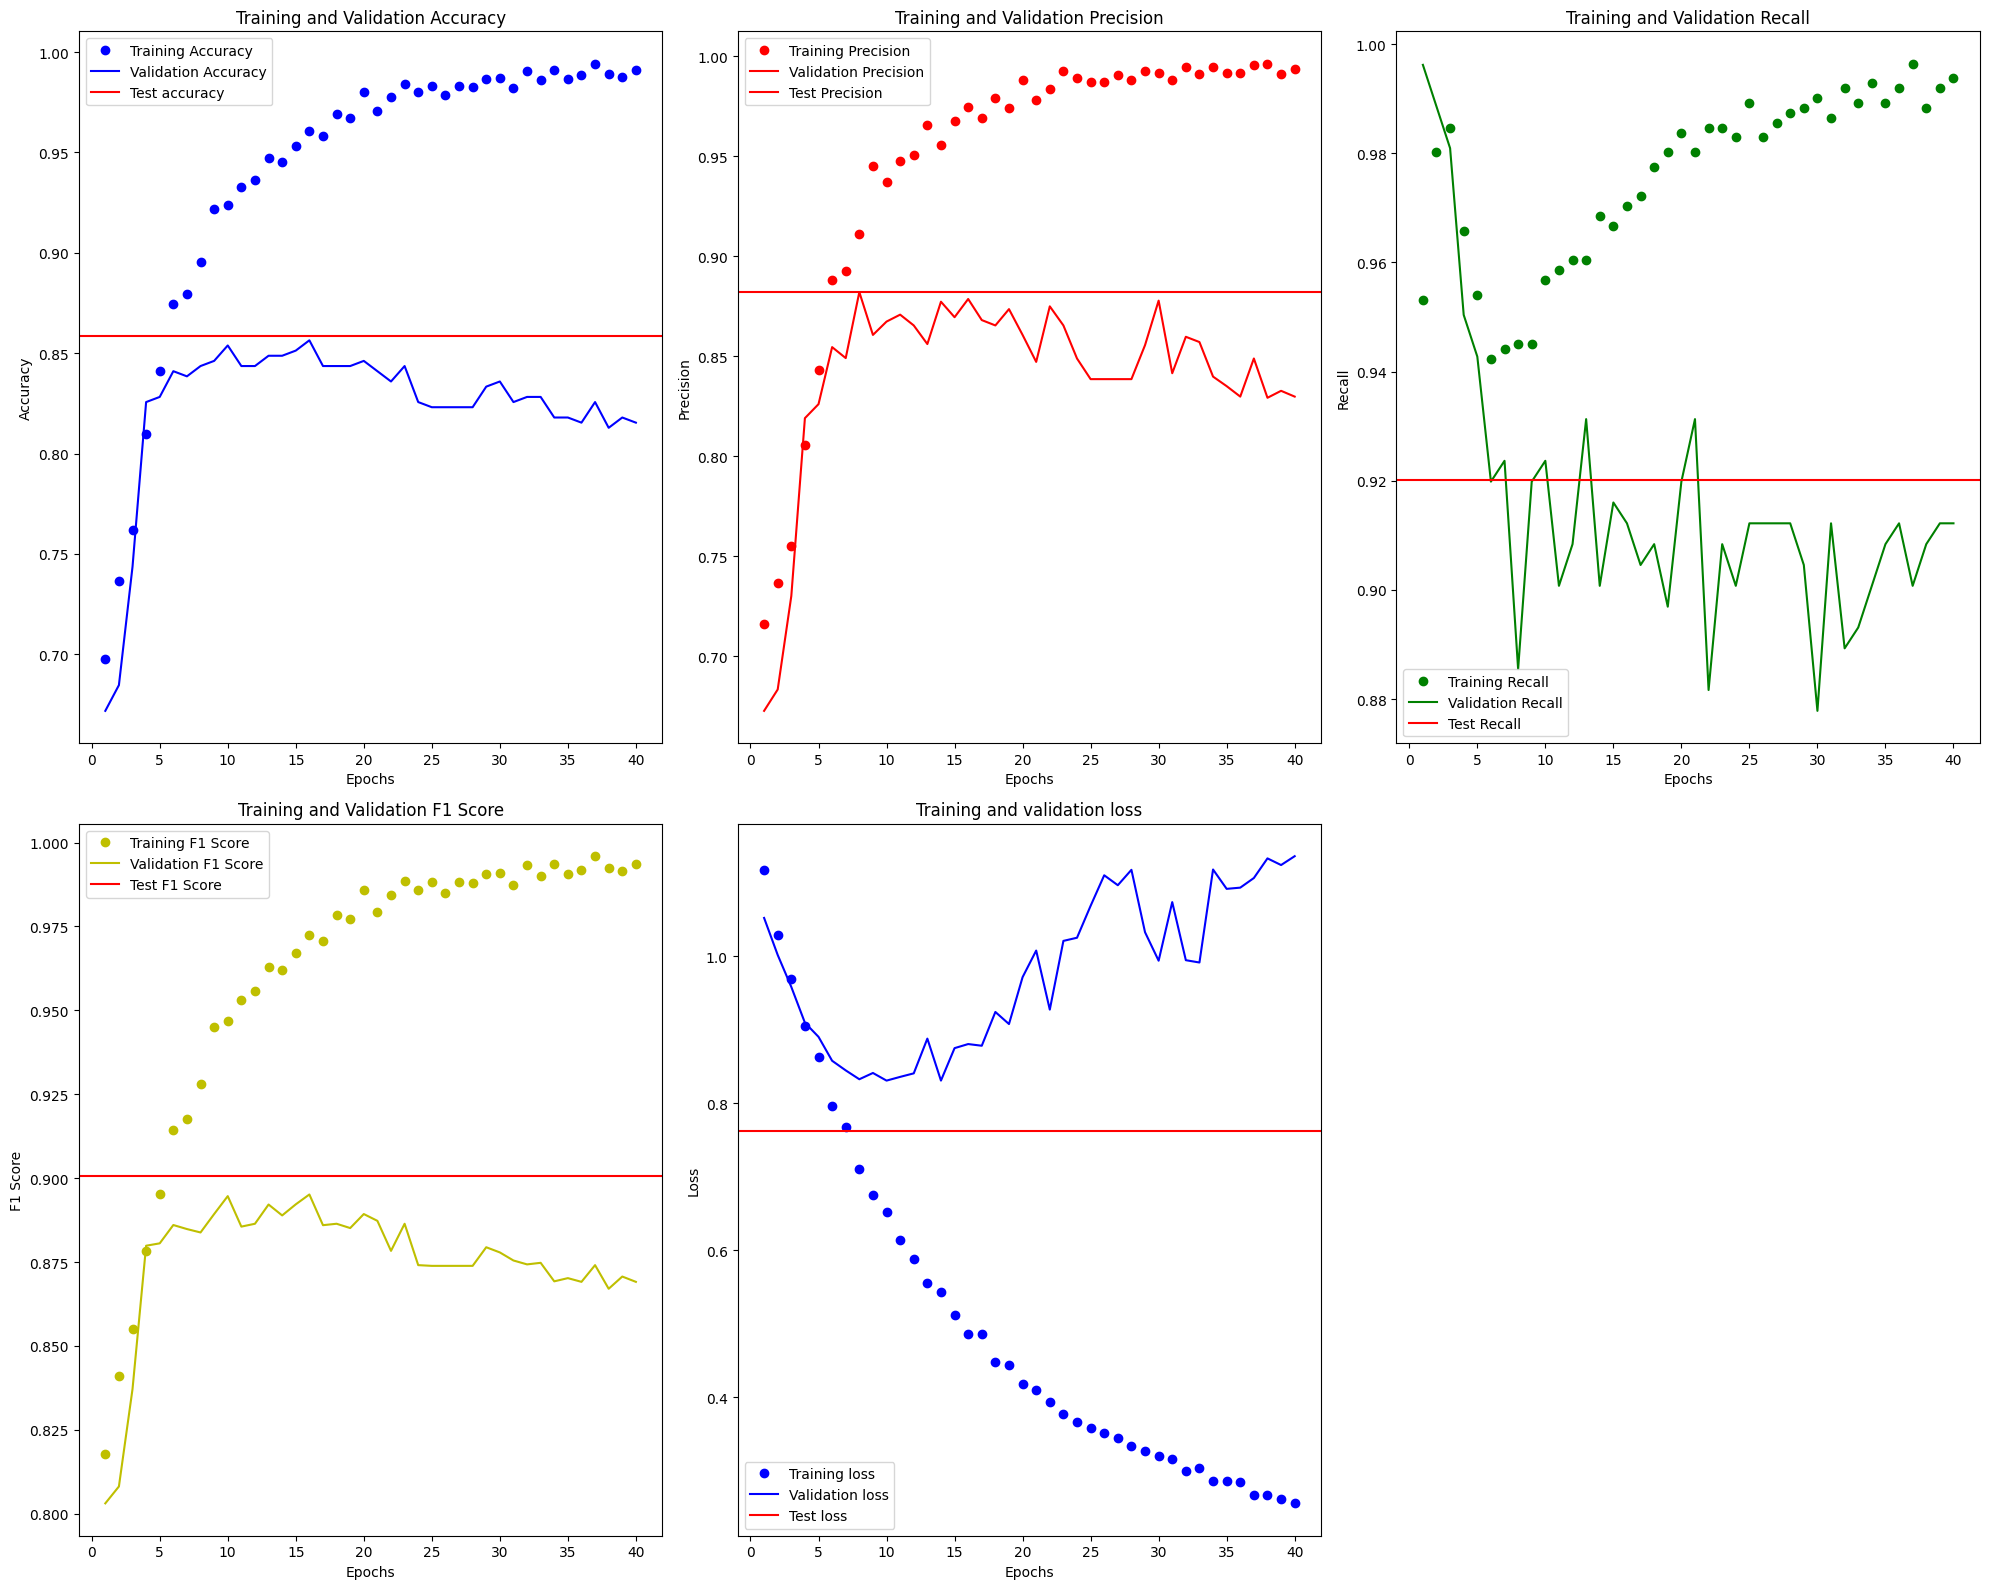

In [122]:
import matplotlib.pyplot as plt

for metric in history_dict.keys():
    if 'val_precision' in metric:
        temp_val_precision = metric
    elif 'precision' in metric:
        temp_precision = metric
        
    if 'val_recall' in metric:
        temp_val_recall = metric
    elif 'recall' in metric:
        temp_recall = metric
        

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

precision = history_dict[temp_precision]
val_precision = history_dict[temp_val_precision]

recall = history_dict[temp_recall]
val_recall = history_dict[temp_val_recall]

f1_score = history_dict['f1_score']
val_f1_score = history_dict['val_f1_score']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, int(len(accuracy) + 1))

plt.figure(figsize=(20, 16))

# Plot training and validation accuracy
plt.subplot(2, 3, 1)
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='-', label='Test accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation precision
plt.subplot(2, 3, 2)
plt.plot(epochs, precision, 'ro', label='Training Precision')
plt.plot(epochs, val_precision, 'r', label='Validation Precision')
plt.axhline(y=test_precision, color='r', linestyle='-', label='Test Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot training and validation recall
plt.subplot(2, 3, 3)
plt.plot(epochs, recall, 'go', label='Training Recall')
plt.plot(epochs, val_recall, 'g', label='Validation Recall')
plt.axhline(y=test_recall, color='r', linestyle='-', label='Test Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plot training and validation F1 Score
plt.subplot(2, 3, 4)
plt.plot(epochs, f1_score, 'yo', label='Training F1 Score')
plt.plot(epochs, val_f1_score, 'y', label='Validation F1 Score')
plt.axhline(y=test_f1score, color='r', linestyle='-', label='Test F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Plot training and validation loss per epoch
plt.subplot(2, 3, 5)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.axhline(y=test_loss, color='r', linestyle='-', label='Test loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
